In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_FILE = "maze.jpg"
thresh = 128
maxval = 255

img_maze = cv2.imread(IMAGE_FILE)
img_hsv = cv2.cvtColor(img_maze, cv2.COLOR_BGR2HSV)

hsv_mask = cv2.inRange(img_hsv, (0,47,0), (23,255, 255))

_, threshed = cv2.threshold(hsv_mask, thresh, maxval, cv2.THRESH_BINARY)
threshed_3_channel = cv2.cvtColor(threshed, cv2.COLOR_GRAY2BGR)

plt.figure(figsize = (9,5))
plt.imshow(threshed_3_channel)


In [29]:
# Task 2.1 (3 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
            self.edges[node_id] = {}
        pass

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight
        pass

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            del self.edges[node_id1][node_id2]
            del self.edges[node_id2][node_id1]
        pass
    
    def get_nodes(self):
        return self.nodes
    
    def get_edge_weight(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2]
        return None 

In [30]:
def path_clear(image, x1, y1, x2, y2):
    roi = image[y1:y2, x1:x2]
    num_points = max(abs(x2 - x1), abs(y2 - y1)) 
    for i in range(num_points + 1):
        x = int(x1 + i * (x2 - x1) / num_points)
        y = int(y1 + i * (y2 - y1) / num_points)
        pixel = image[y, x]
        if (pixel[0] == 255 and pixel[1] == 0 and pixel[2] == 0) or np.all(pixel == [0, 0, 0]):
            return False
        
    # TODO: Check if each pixel is red or black. If yes, ret urn False, otherwise, return True
    return True


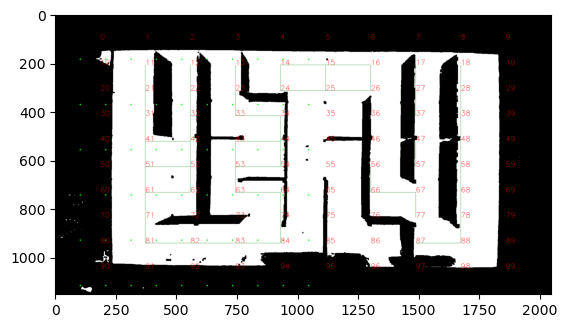

In [38]:
bfs_image = threshed_3_channel.copy()
bfs_graph = Graph()

kernel_size = 5

kernel = np.ones((kernel_size, kernel_size), np.uint8)
bfs_image = cv2.dilate(bfs_image, kernel, iterations = 1)
bfs_image = cv2.erode(bfs_image, kernel, iterations = 1)

node_id = 0

size_of_node_grid = 10 
# Initialize the size of the array
img_height = threshed_3_channel.shape[0]
img_width = threshed_3_channel.shape[1]

grid_spacing_x = img_width // (size_of_node_grid + 1)
grid_spacing_y = img_height // (size_of_node_grid + 1)

# Get nodes
dictionary = bfs_graph.get_nodes()

# Generate nodes
for i in range(size_of_node_grid + 1):
    for j in range(size_of_node_grid + 1):        
        if i != 0 and j != 0:
            x = j * img_width // (size_of_node_grid + 1)
            y = i * img_height // (size_of_node_grid + 1)
            bfs_graph.add_node(node_id, x, y)
            node_id += 1

# Generate edges
for i in range(0, size_of_node_grid * size_of_node_grid, size_of_node_grid):
    for j in range(size_of_node_grid - 1):
        node_id1 = i + j
        node_id2 = node_id1 + 1
        x1, y1 = dictionary[node_id1].get_point()
        x2, y2 = dictionary[node_id2].get_point()
        if path_clear(bfs_image, x1, y1, x2, y2):
            bfs_graph.add_edge(node_id1, node_id2, 1)

for i in range(size_of_node_grid):
    for j in range(0, size_of_node_grid * (size_of_node_grid - 1), size_of_node_grid):
        node_id1 = i + j
        node_id2 = node_id1 + size_of_node_grid
        x1, y1 = dictionary[node_id1].get_point()
        x2, y2 = dictionary[node_id2].get_point()
        if path_clear(bfs_image, x1, y1, x2, y2):
            bfs_graph.add_edge(node_id1, node_id2, 1)
    
# Font settings
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
color = (255, 0, 0)  
thickness = 1

# Display nodes            
for node_id in dictionary:
    x, y = dictionary[node_id].get_point()
    cv2.circle(bfs_image, (y, x), 3, (0, 255, 0), -1)
#     if node_id == 0 or node_id == size_of_node_grid * size_of_node_grid - 1:
    cv2.putText(bfs_image, str(node_id), (x, y), font, font_scale, color, thickness, cv2.LINE_AA)  

# Display edges
for node_id1 in dictionary:
    for node_id2 in dictionary:
        if bfs_graph.get_edge_weight(node_id1, node_id2) != None:
            x1, y1 = dictionary[node_id1].get_point()
            x2, y2 = dictionary[node_id2].get_point()
            cv2.line(bfs_image, (x1, y1), (x2, y2), (0, 125, 0), 1)

# Display Resulting Image
plt.imshow(bfs_image)
plt.show()


In [32]:
# Task 3.2 (4 marks): Impliment BFS
from collections import deque

# Returns an array of nodes in order of which nodes is visited next.
# ie. [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]
def bfs(graph, start_node_id, end_node_id):
    visited = set()
    parents = {start_node_id: None}
    visited.add(start_node_id)
    queue = deque([start_node_id])
    
    
    while queue:
        current_node = queue.popleft()
        for neighbor in graph.edges[current_node]:
            if neighbor not in visited:
                visited.add(current_node)
                parents[neighbor] = current_node
                queue.append(neighbor)
    # Reconstruct the path from end_node_id to start_node_id
    path = []
    if end_node_id in parents:
        current = end_node_id
        while current is not None:
            path.append(current)
            current = parents[current]
        path.reverse()
    
    return path


Path: [11, 21, 31, 41, 51, 61, 71, 81, 82, 83, 84, 74, 64, 63, 53, 43, 44, 34, 33]


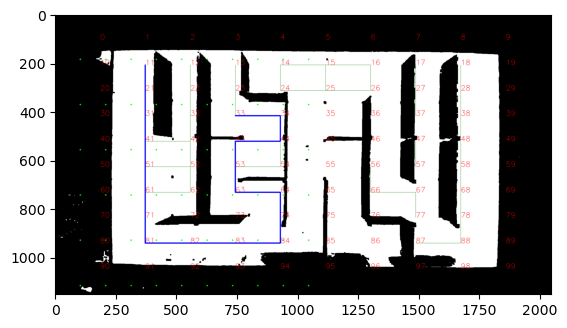

In [39]:
# Task 3.2: Impliment BFS continued

# Run bfs and display the output
path = bfs(bfs_graph,11,33)

# Draw the path
color = (0, 0, 255)  # Blue color in BGR
thickness = 3
for i in range(len(path) - 1):
    node_id1 = path[i] 
    node_id2 = path[i + 1]
    
    x1, y1 = bfs_graph.nodes[node_id1].get_point()
    x2, y2 = bfs_graph.nodes[node_id2].get_point()
    
    cv2.line(bfs_image, (x1, y1), (x2, y2), color, thickness)
    

# Display resulting image
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()
# ie. [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]